The gym chain Model Fitness is developing a customer interaction strategy based on analytical data.
One of the most common problems gyms and other services face is customer churn. How can we know if a customer is no longer with the service? We can calculate churn based on people who get rid of their accounts or don't renew their contracts. However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.
Churn indicators vary from field to field. 
For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.
In order to fight churn, Model Fitness has digitized a number of its customer profiles. Our task is to analyze them and come up with a customer retention strategy.


**The tasks of this analysis are:**
* To learn to predict the probability of churn (for the upcoming month) for each customer
* To draw up typical user portraits: select the most outstanding groups and describe their main features
* To analyze the factors that impact churn most
* To draw basic conclusions and develop recommendations on how to improve customer service:
 * Identify target groups
 * Suggest measures to cut churn
 * Describe any other patterns we will be able to see with respect to interaction with customers
 

### Part 1. First look at the data

In [2]:
# Basic libararies 
import pandas as pd
import numpy as np
# Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import max_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score
# Configuration
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter('ignore')
sns.set_theme(style='darkgrid')

In [3]:
# Customized function for data exploring
def explore(data):
    print('Dataframe Info:')
    print()
    display(data.info())
    print()
    print('-*'*40)
    print()
    print('Missing values:')
    print()
    print(data.isnull().sum())
    print()
    print('-*'*40)
    print()
    print('Duplicated rows: {}'.format(data.duplicated().sum()))
    print()
    print('-*'*40)
    print()
    display(data.head())

In [4]:
# Read the data
try:
    df = pd.read_csv('/content/drive/MyDrive/csv_fies/gym_churn_us.csv')
except:
    df = pd.read_csv('/datasets/gym_churn_us.csv')

In [5]:
explore(df)

Dataframe Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000

None


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Missing values:

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

Duplicated rows: 0

-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*



,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


#### Intermediate conclusions
Our dataset consists of 4000 rows and 14 columns which we will refer to as observations and features respectively. There are no missing values, duplicates or wrong data types. The features we have are: 

* `Churn` — the fact of churn for the month in question, 0 - False or not churned, 1 - True or churned
Current dataset fields:

* `gender` -  0 stands for female, 1 for male
* `Near_Location` — whether the user lives or works in the neighborhood where the gym is located
* `Partner` — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
* `Promo_friends` — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
* `Phone` — whether the user provided their phone number
* `Age`
* `Lifetime` — the time (in months) since the customer first came to the gym
* `Contract_period` — 1 month, 3 months, 6 months, or 1 year
* `Month_to_end_contract` — the months remaining until the contract expires
* `Group_visits` — whether the user takes part in group sessions
* `Avg_class_frequency_total` — average frequency of visits per week over the customer's lifetime
* `Avg_class_frequency_current_month` — average frequency of visits per week over the preceding month
* `Avg_additional_charges_total` — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

Among all the given features we have the `Near_Location`, `Partner`, `Promo_friends`, `Phone`, `Group_visits`, `gender` that are rather qualitative with observations '1/0' that correspond to 'True/False'. 

The `Churn` is our target value, also represented in '1/0'. 

`Age`, `Lifetime`, `Contract_period`, `Month_to_end_contract`, `Avg_class_frequency_total`, `Avg_additional_charges_total` are discrete values.
 
 There are no date or time series in our dataset, no continuous values.

Some of the colums are noted as int64 datatype while they contain only 1 or 0 values, we can simplify the type in order to optimize memory usage.

In [6]:
int_columns = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Contract_period', 'Group_visits', 'Age', 'Lifetime', 'Churn']
df[int_columns] = df[int_columns].astype('uint8')
df[int_columns].dtypes

gender             uint8
Near_Location      uint8
Partner            uint8
Promo_friends      uint8
Phone              uint8
Contract_period    uint8
Group_visits       uint8
Age                uint8
Lifetime           uint8
Churn              uint8
dtype: object

For the simplicity of usage we will lower the case of the names of the columns.

In [7]:
df.columns = df.columns.str.lower()

### Part 2. Exploratory data analysis

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Judging by the *mean values*, typically, a client of the gym can be **29** years old male or female, that has a contract period of **4.5** months with almost **4** months of an overall lifetime as a client of the gym, they would visit the gym around **1.8** times a month and in general, spend extra **146**(dollars? we don't really know the currency), most likely they live **nearby** (85%) and leave their **phone** number in the gyms' database (90%). 

Observing the *standard deviation* we must notice that the values of it mostly are similar to the mean values, so it looks like our features shouldn't have any extreme outliers

In [9]:
df.groupby(['churn']).mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Let's go over this table row by row.
Those, who stayed:
 * 51% of man, 49% of female, 
 * 87% live nearby
 * 53% are participants of the partner program, 
 * 35% are clients thanks to the promotion campaign
 * almost all of the clients left their phone numbers, 
 * 46% of the clients who stayed have group visits, 
 * 5.7 is an average contract period for those who stayed
as well as 5.2 months to end of the contract and with lifetime as a client of the gym 4.7
 * the average age for those who stay is almost 30, just as of the overall dataset
 * 2 classes on average

As for those, who churned:
 * in a similar way to those who stayed: 51% of man, 49% of female,
 * 76% neighbors to the gym, a little bit lower than those who stayed
 * only 35% are participate in the partner programm
 * only 18% came as per the promotion campaign
 * in a similar way to those who stayed: 90% of the clients who left their phone numbers
 * the average contract period is less, than for those who stayed: 1.72 months
 * only 26% had group visits before they churned
 * the average age is as well lower, than for those who stayed - 27 years old
 * the average additional charges are lower as well - 115 (supposedly dollars)
 * the average lifetime is just under 1 month
 * average amount of visits were 1.04 visit in a month and 1.47 in total 
 
On the big picture it looks like some features have lower values in almost every aspect for those who churned when we compare the two groups. Let's conclude the written above:

- The gender distribution is equal for churn and not churn
- Clients living or working closer are less likely to churn
- Employees of partner companies are less likely to stop visiting a fitness club than other clients
- Clients who came via the promotion campaign are half as likely to churn, but there are not much of them in both groups
- The presence of a client's mobile number does not differ in groups
- The average duration of the contract is longer for the remaining users, for most of the clients in the churn, the contract period is 1 month (as well, this could indicate that more often customers conclude a contract for 1 month).
- The remaining users visit group classes more often (also, it is possible that those who have not yet managed to start going to them got into the churn)
- Groups have a difference in the average age of clients - 30 for remaining and 27 for churned
- There is a slight difference in revenue from other fitness center services
- The remaining time to the end of the contract is longer for the remaining customers.
- Churn customers have lower average visits per week over time
- The number of visits in the previous month is two times lower for customers in the churned group


It would be interesting to see, if the overall amount of class `churned` clients is **balanced** with class `not churned` clients. Nevertheless, it is important to say, that clients who churned typically visited the gym 1 or maybe 2 times a month which is twice less than those who stayed, they were considered clients under a month and then stopped attending the fitness center. 

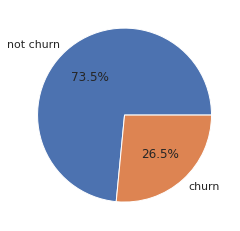

In [10]:
mylabels = ['not churn', 'churn']
plt.pie(df.churn.value_counts(), labels = mylabels, autopct = '%1.1f%%')
plt.show()

As suspected, what we see is that the overall division of classes is **not balanced**, in other words, the groups `churn` and `not churn` are not represented equally in the dataset.

We need some more visualization tools in order to understand the distribution of our features in the most thorough way:
1. We will have a look at the non-boolean numeric and categorical features on histograms
2. We will compare the sum of each feature grouped by the class (churn/not churn) on a barplot
3. We will have a look at the correlation matrix and display it on a heatmap and on a scatterplot matrix

**Plotting histograms can give us the understanding of the form of the distribution and whether we have extreme outliers**

In [11]:
numeric = ['age', 'avg_additional_charges_total', 'contract_period', 'month_to_end_contract', 
          'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

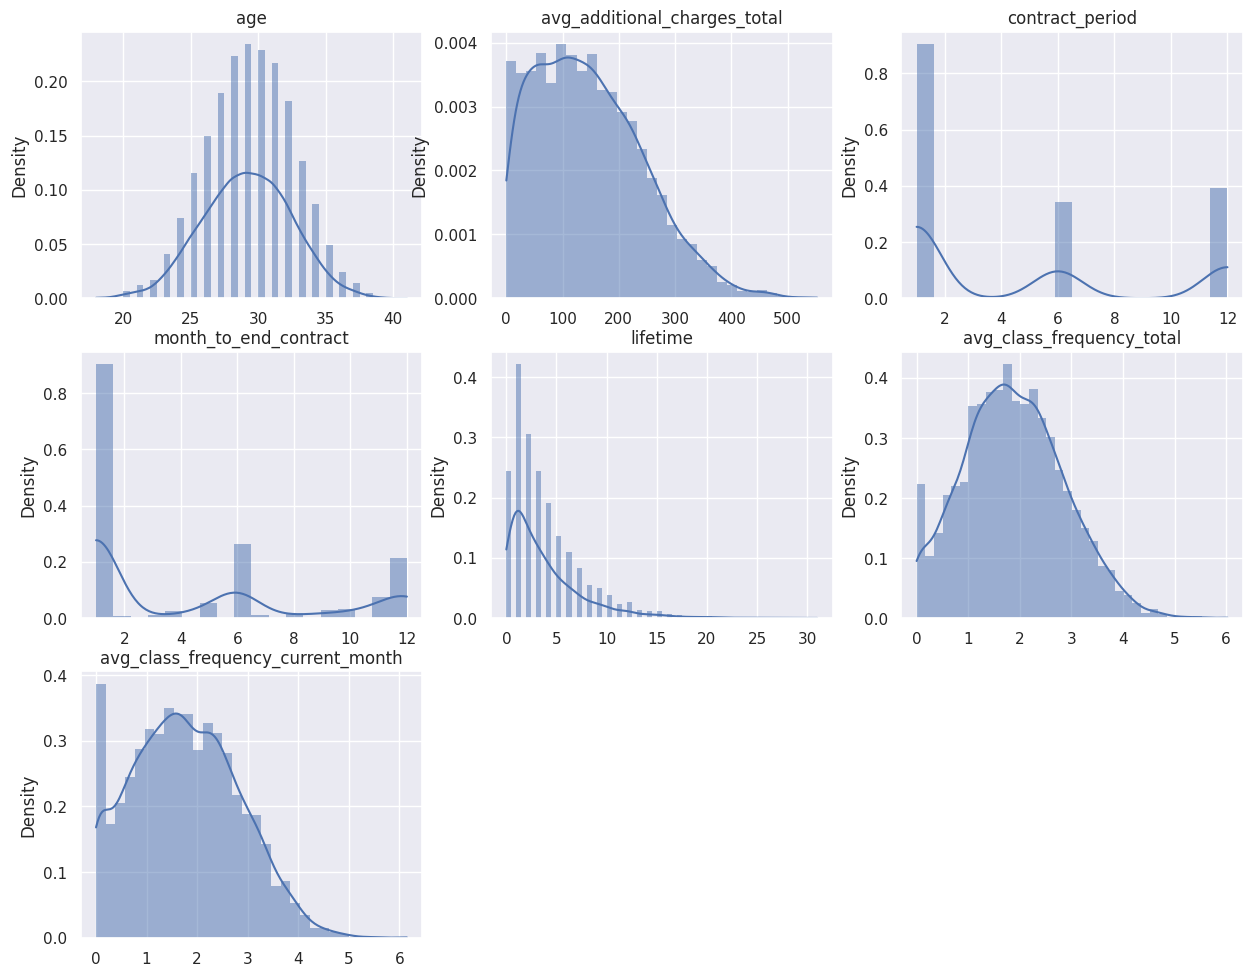

In [12]:
# set number of rows, and columns: 
# since we have 7 features to plot we need a 9X9 canvas
r, c = 3, 3 
# x and y are the coordinates of each graph on the canvas
# on the start of the loop they are equal to 0 (the first position of the canvas) 
# and will be the counters of the loop
x_i, y_i = 0, 0 

# create graph and axes objects with size parameters                
fig, axes = plt.subplots(figsize = (15, 12), dpi = 100) 

# iterate over the necessery columns
for i in df[numeric].columns:
    ax = plt.subplot2grid((r, c), (x_i, y_i))
    ax = sns.histplot(df[i], kde = True, linewidth = 0, stat = 'density')
    plt.xlabel('')
    plt.title(i)
  # after each iteration when 1 graph is ready, we add to the y_i coordinate to move to the next cell of our canvas
    y_i += 1
  # when the last coordinate y_i equals to the column number 
  # we add to the x_i to move to the cell in next row and start columns from the beginning
    if y_i == c: 
        x_i += 1
        y_i = 0


The **age** distribution is perfectly normal, which can tell us that from this point of view the dataset can be referred to as representative. The age of our clients vary from slightly under **20 to 40** with **29 as the average age**. 

**Monthly additional charges** lie in range of **0 to 500**, our clients can spend 0 dollars if they are new to the gym as well as they can spend 500 dollars, we will not consider any outliers here regardless that the distribution is not normal.

**Contract period** is not really a distribution, but rather a representation of numerical categories - we see that **1 month** period is the most popular kind of contract.

**Months to end contract** - we see a lot of observations around the value 1 - if a lot of clients have contract period 1, then the remaining months will be equal to one, there is a straight mathematical dependency between those two.

The distribution of the **lifetime** of our clients is right-skewed positive, it's median will be greater than mean, most of the clients are members of the gym for **0 to 15** months, but there are clients that stay for more than **15 and even 30 months**, they are very valuable and we can't consider them as outliers.

**Monthly and total amount of visits** distributions resemble each other. Both have a lot of observations around 0, but it can be due to new clients, we also need them for our analysis.

**Bar plots can give us an idea of the absolute difference between classes according to each feature**

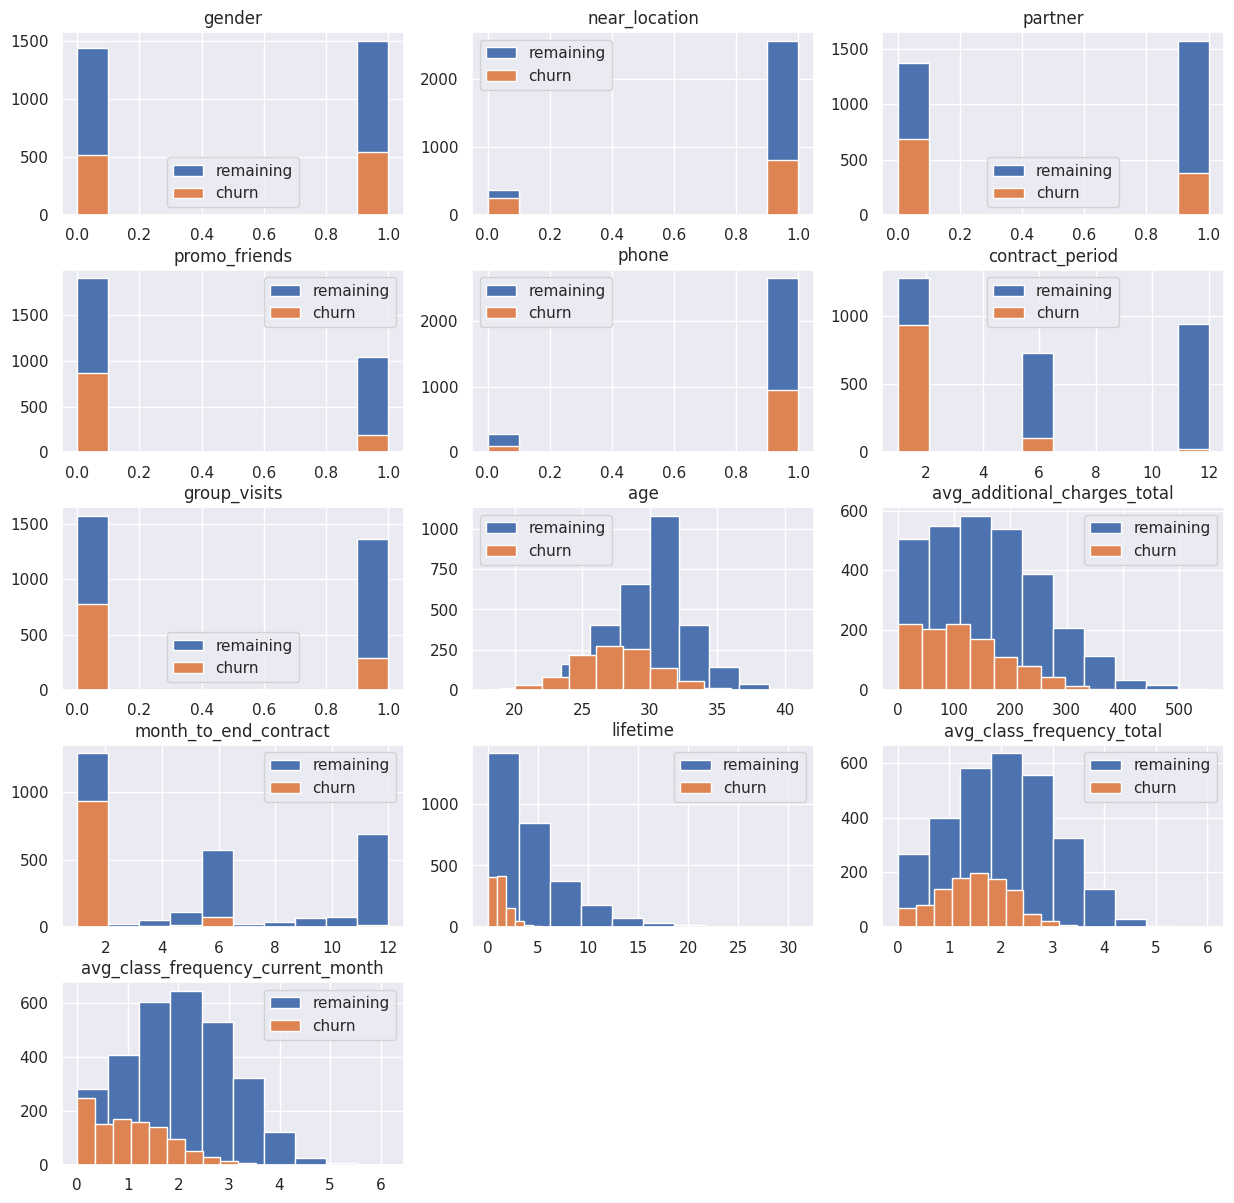

In [13]:
r, c = 5, 3
x_i, y_i = 0, 0

# this time we will examine the sum of all features, grouped by class, where not churn is 0 and churn is 1
fig, axes = plt.subplots(figsize = (15, 15), dpi = 100)

for col in df.drop('churn', axis = 1).columns:
    ax = plt.subplot2grid((r, c), (x_i, y_i))
    ax = df.groupby('churn')[col].hist()
    plt.title(col)
    plt.subplots_adjust(hspace=0.3)
    plt.legend(['remaining', 'churn'])
    y_i += 1
    if y_i == c:
        x_i += 1
        y_i = 0

We can see a similar picture as we did previously. Overall it seems that the clients who stay with the gym have higher values almost for each feature: living in a near location, being a part of partner program and promo campaign, having more group visits, more additional charges, longer lifetime as client in the gym, and frequency of visits. 

Lets' see if we can find strong correlations of any feature with the churn fact.

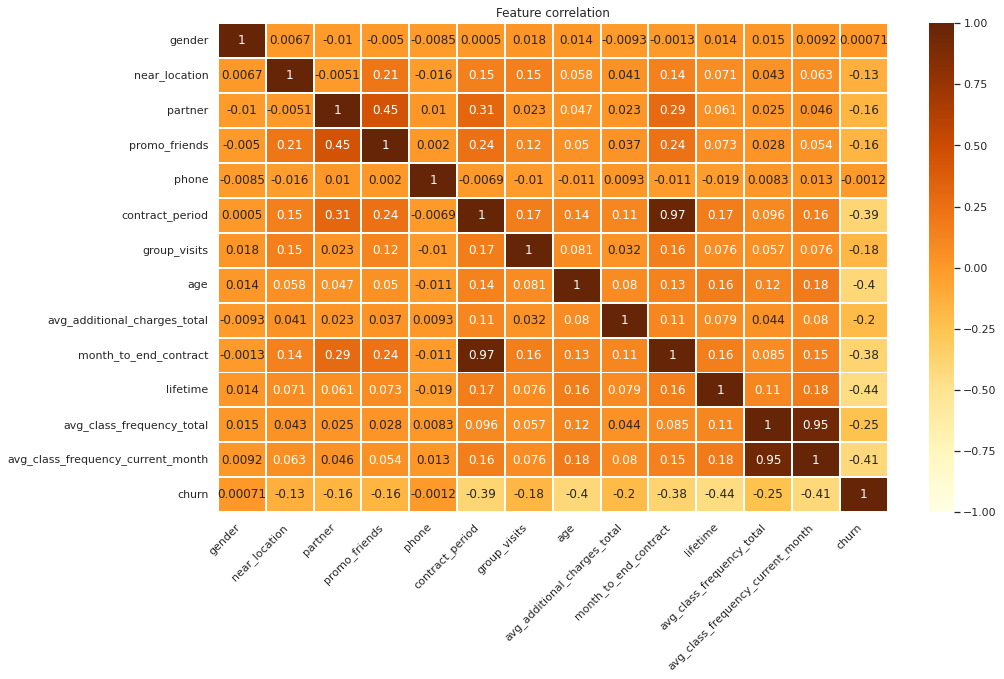

In [14]:
plt.figure(figsize = (15, 9))
ax = sns.heatmap(df.corr(), annot = True, linewidths = 1, 
            cmap = 'YlOrBr', linecolor = 'white', 
            vmin = -1).set_title('Feature correlation')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

Middle **negative correlation** is observed between **churn** and **lifetime (-0.44), monthly average visits (-0.41), age (-0.4), contract period (-0.39) and months to end contract (-0.38)**, rest of the correlations are weak. 

There are two pairs of strongly expressed correlations between **month to end contract and contract period**: as stated before they are mathematically dependant of each other; as well as the **monthly average visits to total average visits** - total is the result of summing and averaging the monthly. Thus we can say, that such features are **multicollinear**. For the purpose of this project we will not remove those columns from the dataset, if the feature importances of the trained model will not show the exact same values in the results.

In [15]:
for_pairplot = ['age',
 'avg_additional_charges_total',
 'contract_period',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month', 'churn']

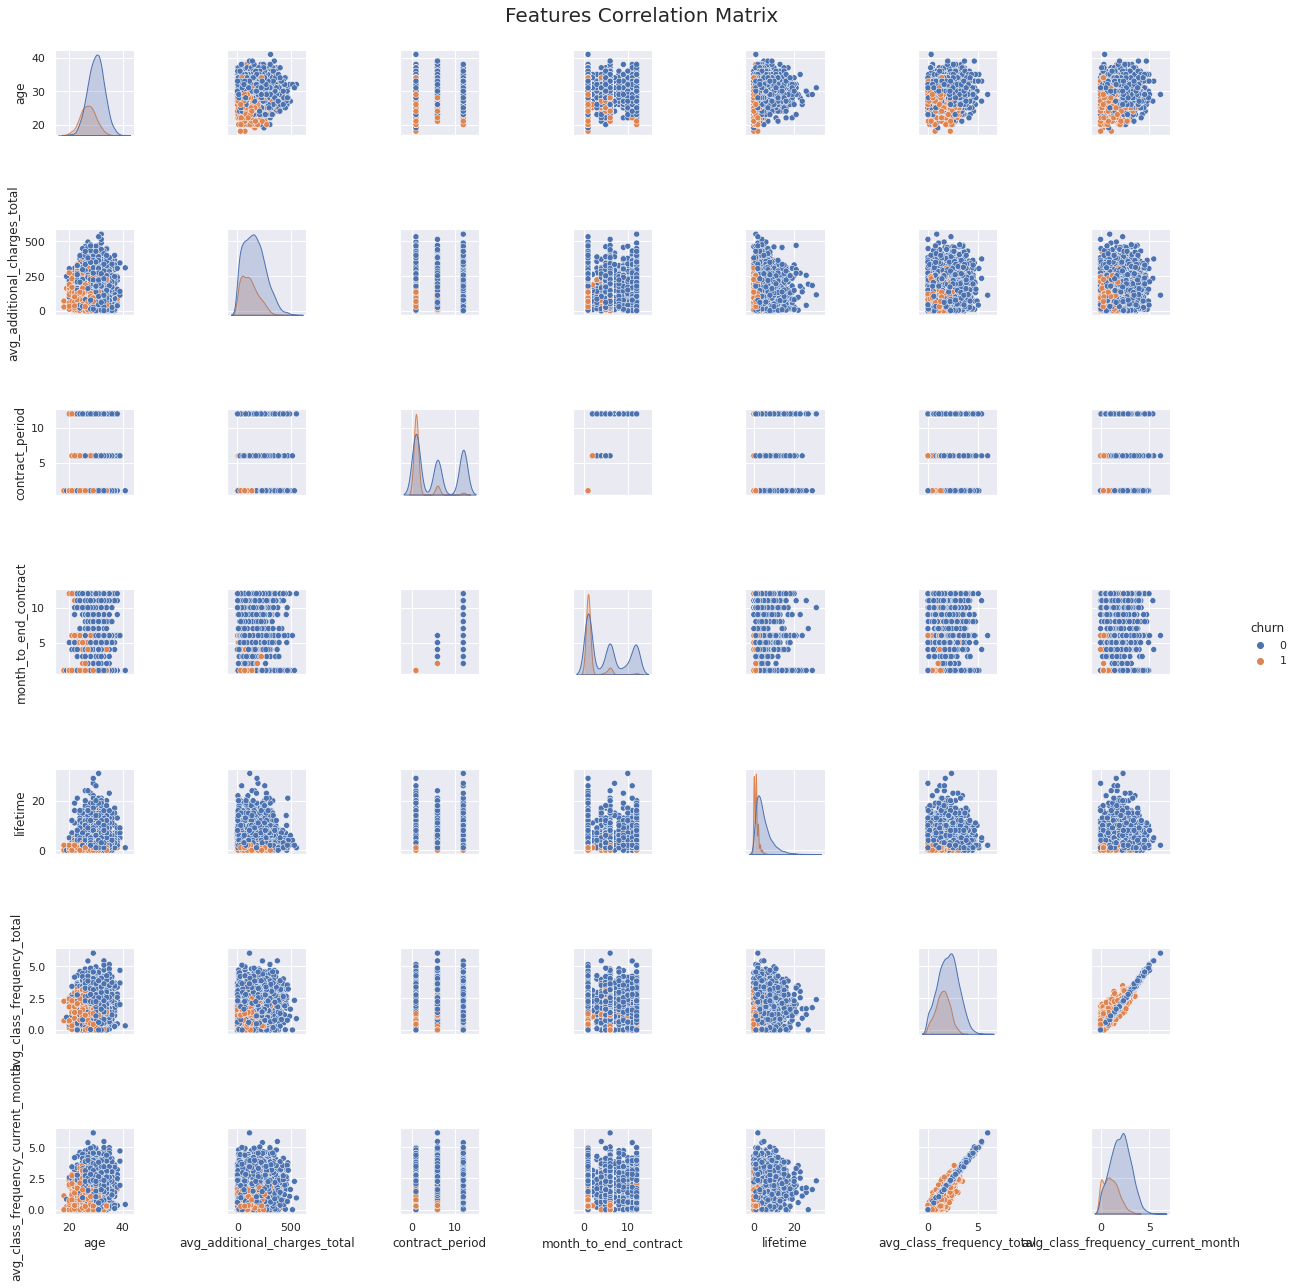

In [16]:
ax = sns.pairplot(df[for_pairplot], hue = 'churn')
ax.fig.suptitle('Features Correlation Matrix', y = 1.02, fontsize = 20)
plt.show()

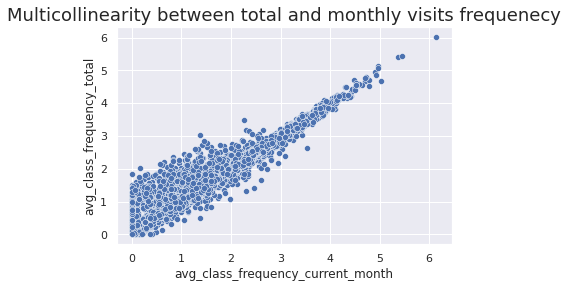

In [17]:
# Take a closer look at the average visits pair: monthly and total
ax = sns.scatterplot(data = df, 
                x = 'avg_class_frequency_current_month', y = 'avg_class_frequency_total')
plt.title('Multicollinearity between total and monthly visits frequenecy', fontsize = 18)
plt.show()

About after the 3-d average amount of visits both of the features become monotonously correlated.

#### EDA conclusions


About a quarter of all clients of the gym for the analyzed period churned. Based on the results of the exploratory analysis, we can say that these clients were less related to the fitness center - less of them are neighbors or participants of partners programs and promo campaigns, in general the average values of the features in this group are lower than among the remaining clients.


None of the features showed a strong correlation with the target variable, only middle negative (lifetime, monthly average visits, age, contract period and months to end contract) Counterintuitively, both gender and the leaving the phone number do not correlate with churn at all, however, we can notice that the shorter the contract period, the time remaining to the end of contact and the average frequency of visits, the higher the probability of the client's churn.

### Part 3. Build a model to predict user churn

To solve this problem we need to associate all of our features to two classes: `churn` / `not churn` and learn our machine to guess each class correctly, when it is given a set of features. This is a **classification** task. To learn to classificate we will examine three most classic algorithms: Logistic regression, Random Forest and a more complex version - Gradient Boosting.

In [18]:
# Set a random state value as constant
RANDOM_STATE = 42

In [19]:
X = df.drop(columns =['churn'], axis = 1) # define the pedictors matrix
y = df['churn'] # define the target value

In order to conduct our learning process we need to split the data:
 1. to training subsets of which we will show our computer so it will be able to find patterns and dependencies 
 2. to test subsets which will not take part in the learning process and will serve the purpose of validating the trained model.


In [20]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = RANDOM_STATE)

In [21]:
X_train, x_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size = 0.25, 
                                                    random_state = RANDOM_STATE)

In [22]:
print(f'80% part - Independent features training set: {X_train_full.shape[0]} rows and {X_train_full.shape[1]} columns')
print(f'80% part - Target values training set: {y_train_full.shape[0]} rows')
print(f'20% part - Independent features test set: {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'20% part - Target values test set: {y_test.shape[0]} rows')
print(f'60% part - Independent features training set: {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'60% part - Target values training set: {y_train.shape[0]} rows')
print(f'20% part - Independent features validation set: {x_valid.shape[0]} rows and {x_valid.shape[1]} columns')
print(f'20% part - Target values validation set: {y_valid.shape[0]} rows')

80% part - Independent features training set: 3200 rows and 13 columns
80% part - Target values training set: 3200 rows
20% part - Independent features test set: 800 rows and 13 columns
20% part - Target values test set: 800 rows
60% part - Independent features training set: 2400 rows and 13 columns
60% part - Target values training set: 2400 rows
20% part - Independent features validation set: 800 rows and 13 columns
20% part - Target values validation set: 800 rows


We have chosen several algorithm implementations from the `sklearn` library - Logistic regression, Logistic regression with cross validation, Random forest classifier and Gradient boosting classifier. For some of them to perform properly our splitted samples need to be scaled.

In [23]:
scaler = StandardScaler()
scaler.fit(X_train)
X_sc_train = scaler.fit_transform(X_train)
X_sc_test = scaler.transform(X_test)
x_sc_valid = scaler.transform(x_valid)

We are preparing several functions to make the process of choosing the best model easier and faster.

In [24]:
# Fit the chosen model and evaluate error metrics of regression
def evaluate_regression(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('MAE:{:.3f} MSE:{:.3f} R2:{:.3f}'\
          .format(mean_absolute_error(y_test, y_pred), 
          mean_squared_error(y_test, y_pred),
          r2_score(y_test, y_pred)))

In [25]:
# Fit the chosen model and evaluate metrics for classification
def evaluate_classification(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    metrics_dict = {'Accuracy': accuracy_score(y_test, y_pred), 
                    'Precision': precision_score(y_test, y_pred), 
                    'Recall': recall_score(y_test, y_pred),
                    'F1': f1_score(y_test, y_pred),
                    'ROC_AUC': roc_auc_score(y_test, proba)}
 
    display(pd.DataFrame([metrics_dict]).T)
    return metrics_dict

In [26]:
# LogisticRegression
evaluate_regression(m = LogisticRegression(
    random_state=RANDOM_STATE, solver = 'newton-cg'), 
    X_train = X_train, y_train = y_train,
    X_test = X_test, y_test = y_test)

MAE:14.691 MSE:0.086 R2:0.543


We trained our first model and evaluated the erros it makes in predicting churn. But it seems like the errors are hard to interpret: judging by the mean square error the result is 0.084 - in what units? Is it 0.084 churns? The errors don't make sense for our case, so we will evaluate our models by **Accuracy, Precision, Recall, F1_score and ROC AUC** metrics. 
Accuracy alone won't let us evaluate the model properly, so since precision and recall are aimed at avoiding opposing risks, we need a harmonizing metric that takes into account the balance between the metrics. This metric is the F1 score will be our main metric of interest.

In [27]:
lr_predictions = evaluate_classification(m = LogisticRegression(
    random_state = RANDOM_STATE, solver = 'newton-cg'), 
    X_train = X_sc_train, y_train = y_train,
    X_test = X_sc_test, y_test = y_test)

,0
Accuracy,0.915000
Precision,0.876404
Recall,0.772277
F1,0.821053
ROC_AUC,0.970082


Great results! Let's see if we can make them better with a different model:

In [28]:
# Logistic regression with cross validation
lr2_predictions = evaluate_classification(m = LogisticRegressionCV(
    random_state = RANDOM_STATE, solver = 'newton-cg'), 
    X_train = X_sc_train, y_train = y_train,
    X_test = X_sc_test, y_test = y_test)

,0
Accuracy,0.920000
Precision,0.883333
Recall,0.787129
F1,0.832461
ROC_AUC,0.969121


All the metrics are  just a little bit worse, than with the old regular Logistic regression, almost each metric decreased by 0.001 or more, except from the recall, but the difference is really small. Let's try another model.

The **Random Forest Classifier** has a lot of hyperparameters that can have an impact on the quality of the predictions of our model. That being said, lets try to find a good score depending on the number of estimators.

In [29]:
score = 0
n_estimators = 1

for i in range(1, 501, 10):
    m = RandomForestClassifier(n_estimators = i, random_state = RANDOM_STATE)
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)
    score_test = recall_score(y_test, predictions)
    if score_test > score:
        score = score_test
        n_estimators = i
print(score)
print(n_estimators)

0.8168316831683168
351


In [30]:
# RandomForestClassifier
rf_predictions = evaluate_classification(m = RandomForestClassifier(
    n_estimators = n_estimators, random_state = RANDOM_STATE), 
    X_train = X_sc_train, y_train = y_train,
    X_test = x_sc_valid, y_test = y_valid)

,0
Accuracy,0.907500
Precision,0.852535
Recall,0.814978
F1,0.833333
ROC_AUC,0.970843


Not so impressive as well, Logistic regression is still the leader. Lets' optimize to the max! We can make our metrics score even better. We can use the Randomized Search CV(cross validation). This method will allow us to find the best combination out of N_hyperparameters.

In [31]:
# Define all the hyperparameters to choose from
grid = {'n_estimators': [10, 100, 200, 500],
        'max_depth' : [None, 5, 10, 20, 30],
        'max_features': ['auto', 'sqrt'], 
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2, 4]  
}

clf = RandomForestClassifier(n_jobs = 1)

rs_clf = RandomizedSearchCV(estimator = RandomForestClassifier(
    random_state = RANDOM_STATE), 
    param_distributions = grid, 
    n_iter = 20, 
    cv = 5, 
    verbose = 2)

In [32]:
rs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=10; tot

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500]},
                   verbose=2)

In [33]:
# Retrieve the best parameters
rs_clf.best_params_

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 200}

In [34]:
rf_improved_predictions = evaluate_classification(m = RandomForestClassifier(
    n_estimators = rs_clf.best_params_['n_estimators'],
    min_samples_split = rs_clf.best_params_['min_samples_split'],
    min_samples_leaf = rs_clf.best_params_['min_samples_leaf'],
    max_features = rs_clf.best_params_['max_features'],
    max_depth = rs_clf.best_params_['max_depth'],
    random_state=RANDOM_STATE), 
    X_train = X_sc_train, y_train = y_train, X_test = x_sc_valid, y_test = y_valid)

,0
Accuracy,0.910000
Precision,0.863850
Recall,0.810573
F1,0.836364
ROC_AUC,0.969801


Looks like we made the best possible out of the Random Forest. Lets' see how the Gradient boosting performs.

In [35]:
# GradientBoostingClassifier
gb_predictions = evaluate_classification(m = GradientBoostingClassifier(
    random_state = RANDOM_STATE), 
    X_train = X_train, y_train = y_train,
    X_test = X_test, y_test = y_test)

,0
Accuracy,0.930000
Precision,0.888298
Recall,0.826733
F1,0.856410
ROC_AUC,0.970131


Now we have an idea about each one of the models, and we can visualize our metrics all together.

In [36]:
compare_results = pd.DataFrame({'logistic regression V1': lr_predictions,
                                'logistic regression V2': lr2_predictions,
                                'random forest V1': rf_predictions,
                                'random forest V2': rf_improved_predictions, 
                                'gradient boosting': gb_predictions
})

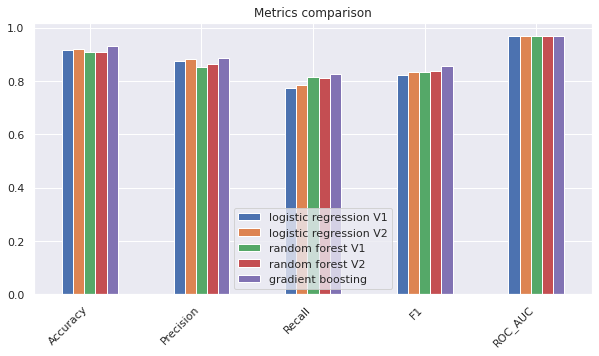

In [37]:
compare_results.plot.bar(figsize = (10, 5))
plt.xticks(rotation = 45, ha = 'right')
plt.title('Metrics comparison')
plt.show()

In [38]:
compare_results.style.highlight_max(axis = 1, color = 'lightgreen')

,logistic regression V1,logistic regression V2,random forest V1,random forest V2,gradient boosting
Accuracy,0.915000,0.920000,0.907500,0.910000,0.930000
Precision,0.876404,0.883333,0.852535,0.863850,0.888298
Recall,0.772277,0.787129,0.814978,0.810573,0.826733
F1,0.821053,0.832461,0.833333,0.836364,0.856410
ROC_AUC,0.970082,0.969121,0.970843,0.969801,0.970131


The gradient boosting turned out to have the highest metrics, so we can use it to predict our target value.

In [39]:
# Train the model
model = GradientBoostingClassifier(random_state = RANDOM_STATE)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


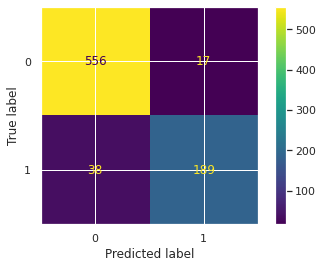

In [40]:
plot_confusion_matrix(model, x_valid, y_valid) 
plt.show()

In [41]:
y_pred = model.predict(x_valid)
cm_model = confusion_matrix(y_valid, y_pred = y_pred)
tn, fp, fn, tp = cm_model.ravel()
print('True Negatives: ',tn)
print('False Positives: ',fp)
print('False Negatives: ',fn)
print('True Positives: ',tp)

True Negatives:  556
False Positives:  17
False Negatives:  38
True Positives:  189


The model has mistaken in 17 cases of predicting positive outcome (client churned), and in 38 cases of predicting negative (client have not churned). 

In [42]:
# Observe feature importances
features = pd.DataFrame(model.feature_importances_) 
features['feature'] = X.columns
features.columns = ['coeff', 'feature']
features = features.reindex(columns = ['feature', 'coeff'])
features.sort_values(by = 'coeff', ascending = False)

,feature,coeff
10,lifetime,0.429339
12,avg_class_frequency_current_month,0.164928
11,avg_class_frequency_total,0.132915
7,age,0.121910
9,month_to_end_contract,0.068560
5,contract_period,0.051831
8,avg_additional_charges_total,0.024122
6,group_visits,0.004685
1,near_location,0.000633
3,promo_friends,0.000523


The most influent feature for positive result (client churned) is lifetime. If all other feature coefficients wouldn't change and together with that the lifetime value would have increased by 1%, than the probability of predicting churn would have changed by 44%. As we remember from the heatmap - lifetime and churn were middle-level correlated as well as other features: monthly and total average visits, age, contract period and months to end contract are at the top of our feature importances table.

Let's run a simple random test on our model. We will simulate a client that does not exist in our dataset by creating it manually and pass it to our model and see what the outcome we will get.

#### ML conclusions

We splitted and scaled our dataset, defined the task and the methods for solving our prediction problem and picked **5 algorythm** implementations to manage the task.

Out of the chosen models `Logistic regression`, `Random Forest` and a more complex version - `Gradient Boosting` we tuned the `Logistic regression` and the `Random Forest` and after observing and comparing the evaluation metrics we stoped our choice on the `Gradient Boost Classifier` with F1 score equals to 0.84. 
We learned that the most important features for our model were **lifetime, monthly and total average visits, age, contract period and months to end contract**.


### Part 4. Create user clusters

Cluster analysis uses mathematical models to discover groups of similar customers based on the smallest variations among customers within each group. In the context of customer segmentation, cluster analysis is the use of a mathematical model to discover groups of similar customers based on finding the smallest variations among customers within each group. These homogeneous groups are known as “customer archetypes” or “personas”.

The goal of cluster analysis in marketing is to accurately segment customers in order to achieve more effective customer marketing via personalization. A common cluster analysis method is a mathematical algorithm known as k-means cluster analysis, sometimes referred to as scientific segmentation. The clusters that result assist in better customer modeling and predictive analytics, and are also used to target customers with offers and incentives personalized to their wants, needs and preferences. We will begin our clustering process with hierarchical clustering to estimate the number of clusters we may have.

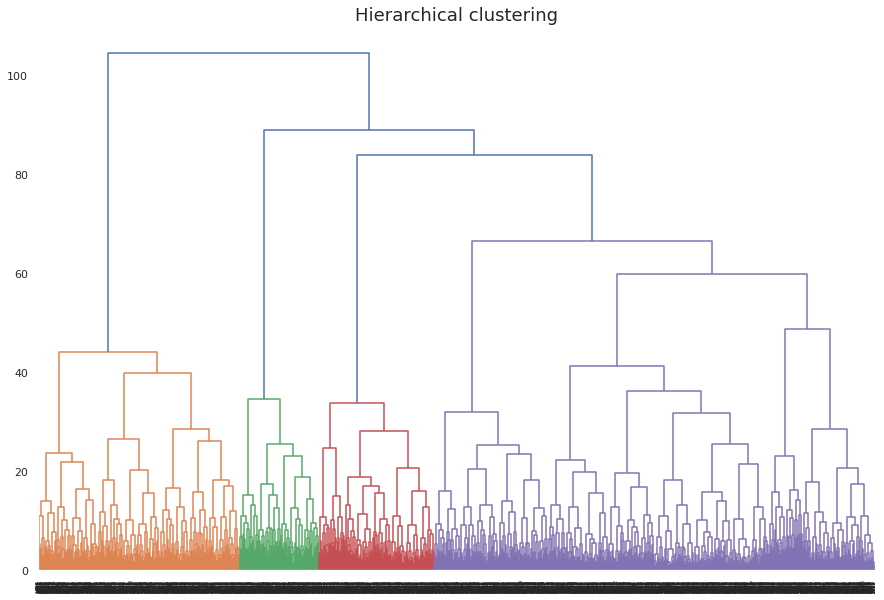

In [43]:
# Standartize the feature matrix 
X_st = scaler.fit_transform(X)
linked = linkage(X_st, method = 'ward')
plt.figure(figsize = (15, 10))
dendrogram(linked, orientation = 'top')
plt.title('Hierarchical clustering', fontsize=18)
plt.show()

The algorithm managed to distinguish between 4 clusters, however, one of them is seemingly bigger than the others, sometimes it can happen due to very close distance between some features and lack of predetermined number of clusters. Applying the KMeans algorithm implementation we can set the number of clusters beforehand and take a closer look at the clients in each cluster to analyze what characterizes them.

In [44]:
km = KMeans(n_clusters = 5, random_state = RANDOM_STATE)
labels = km.fit_predict(X_st)
df['cluster_km'] = labels

In [45]:
df['cluster_km'].value_counts().sort_index()

0     633
1     889
2     865
3    1227
4     386
Name: cluster_km, dtype: int64

Thus, we picked out 2 large clusters with 1010-1262 clients, 1 middle sized with 838 clients and two relatively small with 385-505 clients. Let's take a look at how their features are distributed among them.

In [46]:
df.groupby('cluster_km', as_index = False).mean().T

,0,1,2,3,4
cluster_km,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.502370,0.554556,0.499422,0.485738,0.523316
near_location,0.949447,0.849269,0.937572,0.718011,0.862694
partner,0.829384,0.263217,0.737572,0.299919,0.471503
promo_friends,0.998420,0.052868,0.478613,0.018745,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.097946,2.606299,11.854335,1.914425,4.777202
group_visits,0.448657,0.436445,0.546821,0.276284,0.427461
age,29.104265,30.008999,29.905202,28.083945,29.297927
avg_additional_charges_total,141.774331,159.774265,163.509804,129.496414,144.208179


We can see that in all clusters the gender distribution is more or less equal.

It is also noticeable that in each of the clusters we can highlight some unique characteristic:

**cluster 0** - (1010 clients) - all clients of this cluster left their phone number in the fitness centers database and the churn rate here is the lowest - 0.2%, their average contract period was the longest one - 10.8 months.
**cluster 1** - (385 clients) - didn't leave their phone number, 4.7 average contract period, churn rate 26%
**cluster 2** (505 clients) - on average younger than the clients in the previous two clusters, don't live nearby, have their phone number in the database, churn 44%
**cluster 3** (1262 clients) - almost all metrics in this cluster are low and indicate a loose connection between the client and the club - the shortest average memberships, lifetime and average attendance, while this is the most numerous cluster, churn 51%
**cluster 4** (838 clients) - on average the oldest one with the highest additional charges, longest lifetime as the client, but unlike the 0-th cluster have a short period of contract 2.6. churn 0.6%

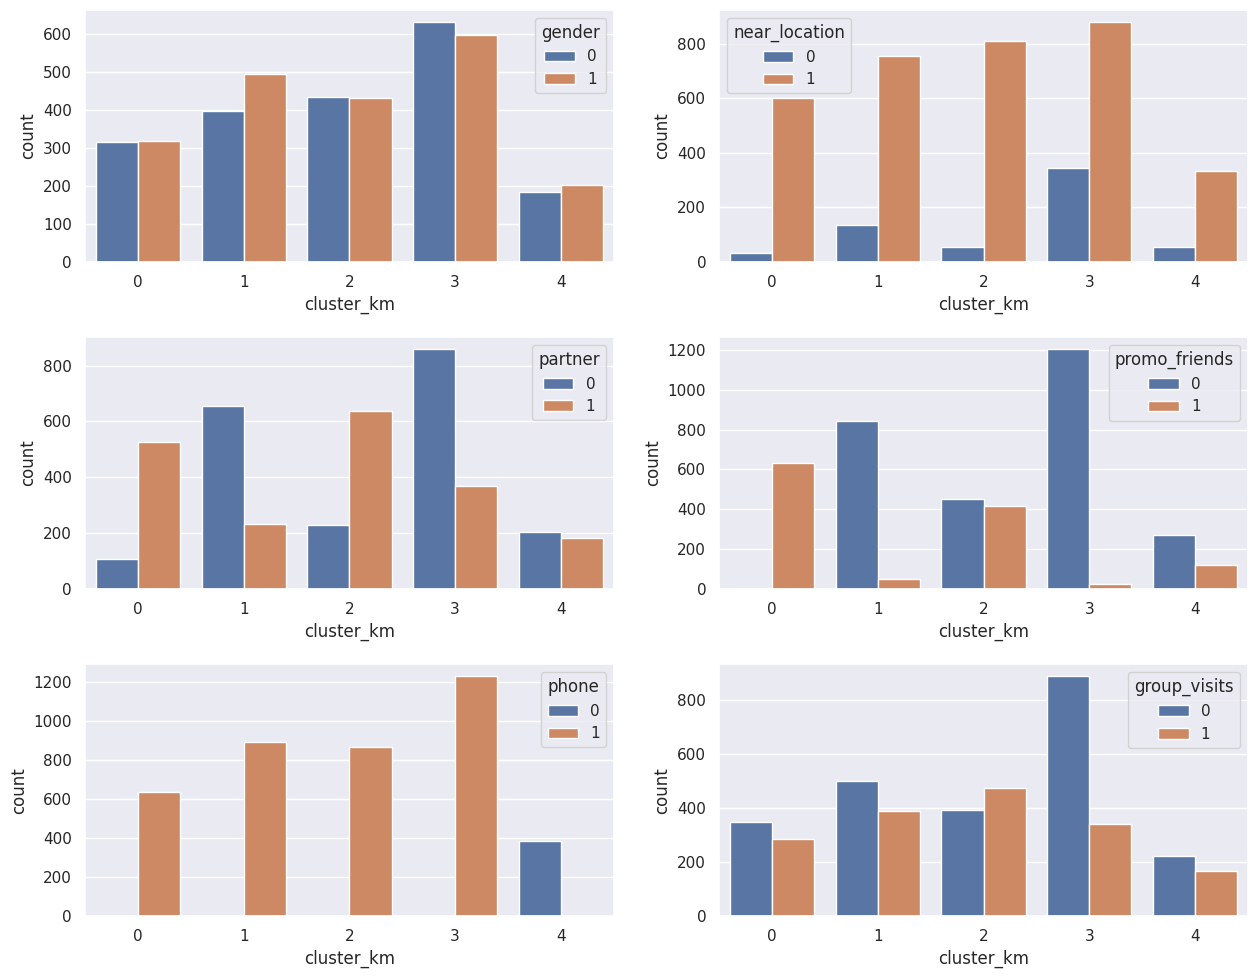

In [47]:
r, c = 3, 2
x_i, y_i = 0, 0
# Draw bar plots for categorical features
fig, axes = plt.subplots(r, c, figsize = (15, 12), dpi = 100)
for i in ['gender', 'near_location', 'partner', 
           'promo_friends', 'phone', 'group_visits']:
    sns.countplot(data = df, x = 'cluster_km', hue = i, ax = axes[x_i, y_i])
    plt.subplots_adjust(hspace = 0.3)
    y_i += 1
    if y_i == c:
        x_i += 1
        y_i = 0

Let's describe each graph individually:
- The division of **genders** is more or less **equal in each cluster**
- **cluster 2** are all clients living **nearby**, **clusters 0, 1 and 4**  are for clients who **mostly don't live nearby**, clients in **cluster 3** don't live nearby at all.
- **cluster 3 and 4** mostly for clients within partner programm, on the opposite is **cluster 0** where most of clients aren't in the partner program, **clusters 1 and 2** have a slight predominance in the number of clients within the partner program
- The majority of clients in **cluster 2, 4, 3 and 1** respectively are participants of the promotion campaign **'friend brings a friend'**
- Clients from **clusters 0, 2, 3 and 4 didn't leave their phone numbers**, only clients from **cluster 0** have
- Clients in **cluster 0** rather **had group visits** than hadn't, in **clusters 2 and 3** the majority of clients **had group visits**, in clusters 1 and 4 a little bit more clients hadn't group visits than had.

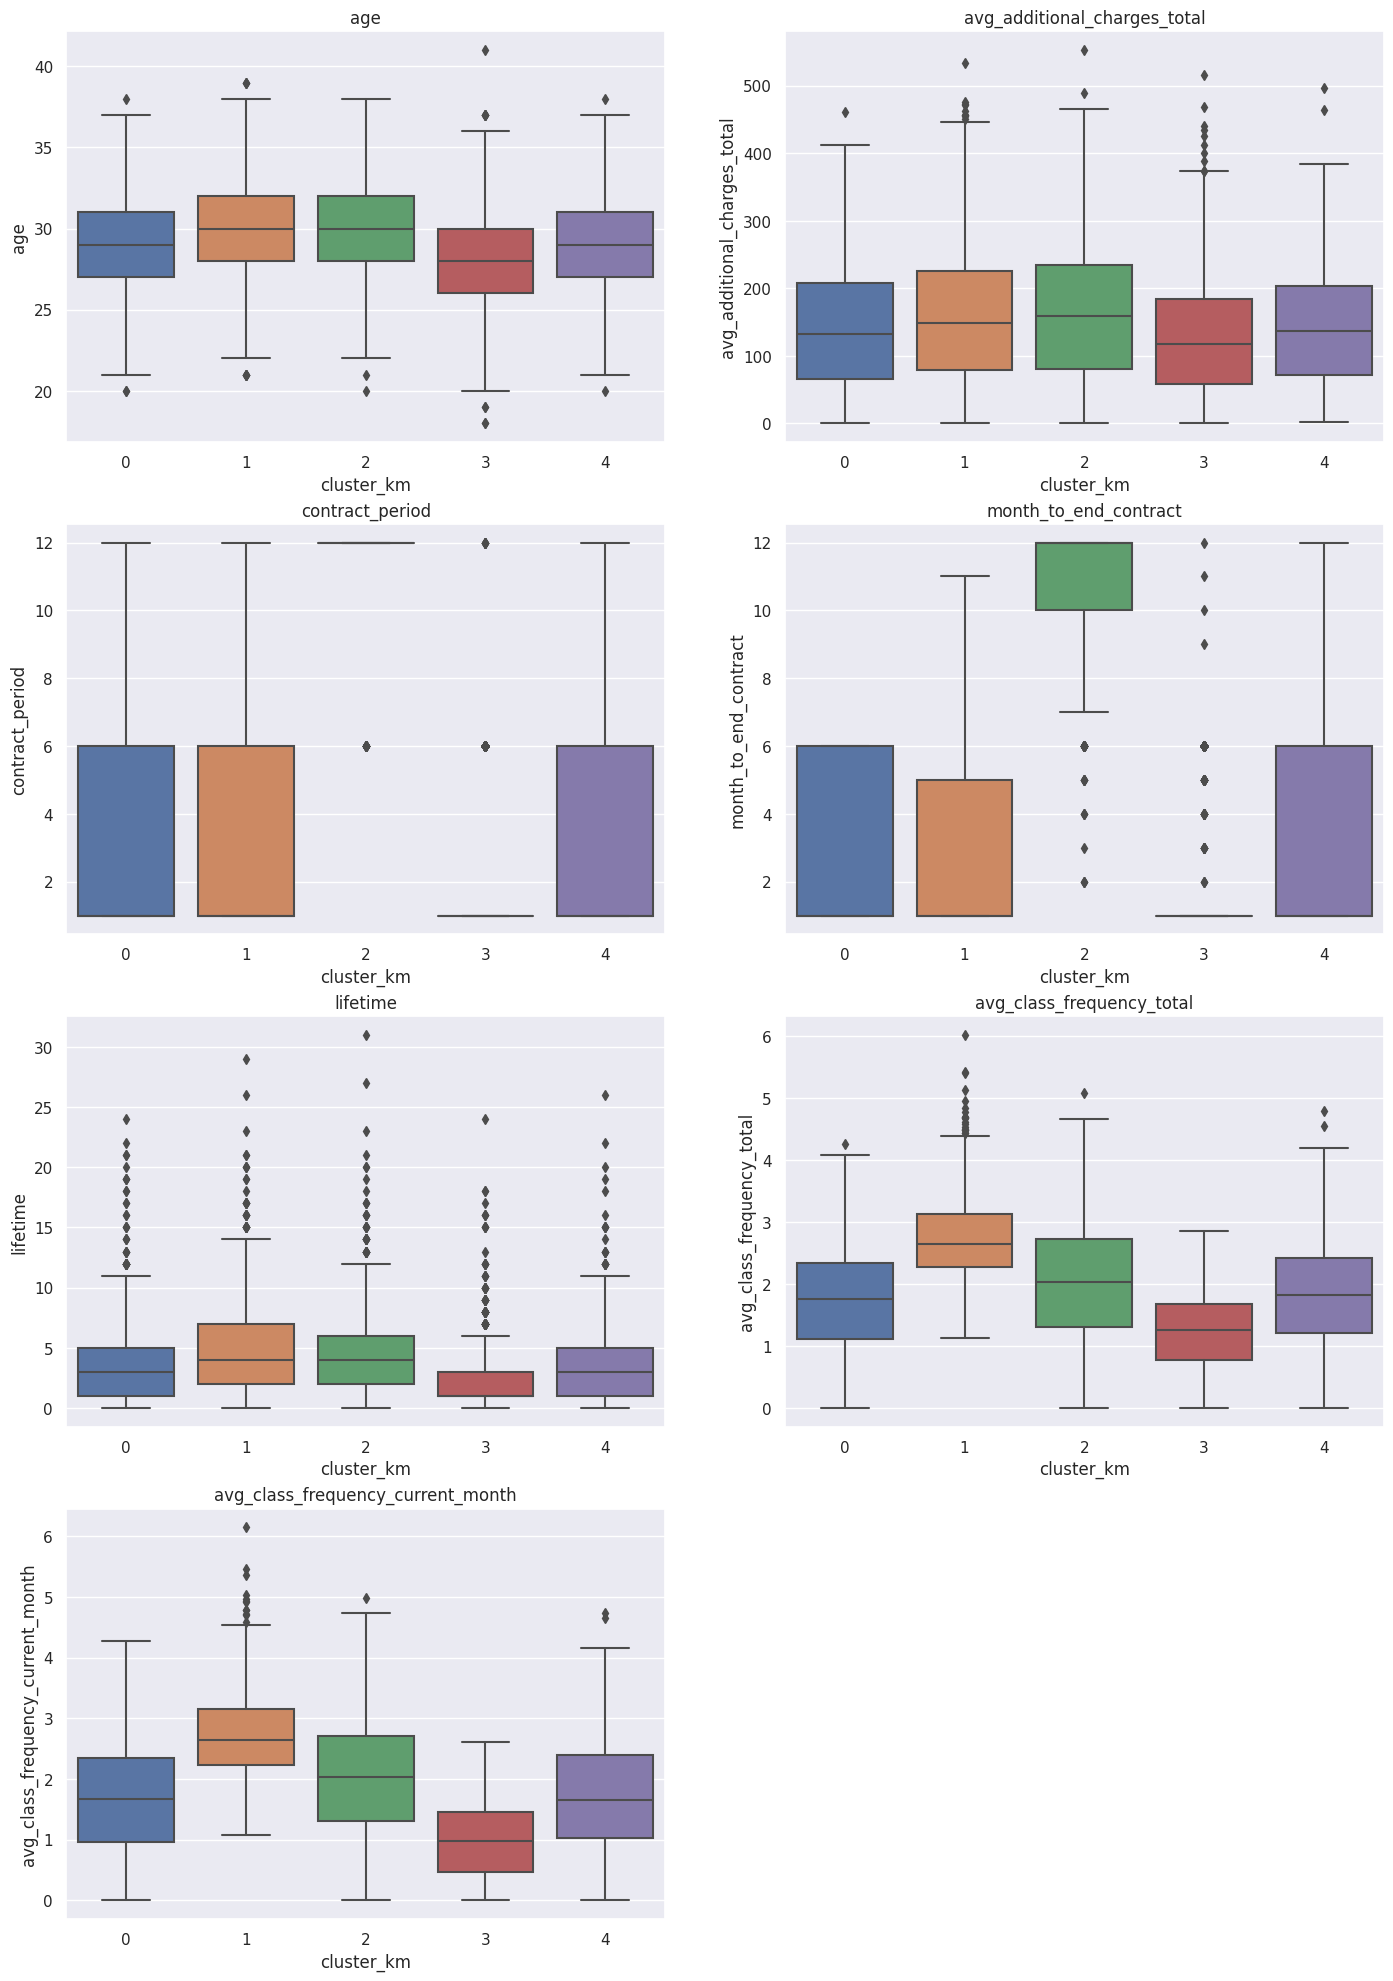

In [48]:
r, c = 4, 2
x_i, y_i = 0, 0
# Draw boxplots for the numerical variables
fig, axes = plt.subplots(figsize = (17, 25), dpi = 100)
for i in numeric:
    ax = plt.subplot2grid((r, c), (x_i, y_i))
    sns.boxplot(data = df, y = i, x = 'cluster_km')
    ax.set_title(i)
    y_i += 1
    if y_i == c:
        x_i += 1
        y_i = 0

- **clusters 0 and 4** have the **highest median age**, the youngest clients, judging by the median are at **cluster 3**
- The highest median of **additional charges** belong to **clusters 0 and 4**, rest of the clients on average spend less money on additional services
- The longest contract period are at cluster 0 - around 12 months, **clusters 2 and 3** are mostly short-termed contract and **clusters 1 and 4** are we can say middle termed
- **clusters 0 and 4** have the longest lifetimes, **cluster 4** is even a little longer on average, **cluster 3** has the shortest lifetime
- **cluster 4** visits the fitness center most often, **cluster 3** apparently skips the classes



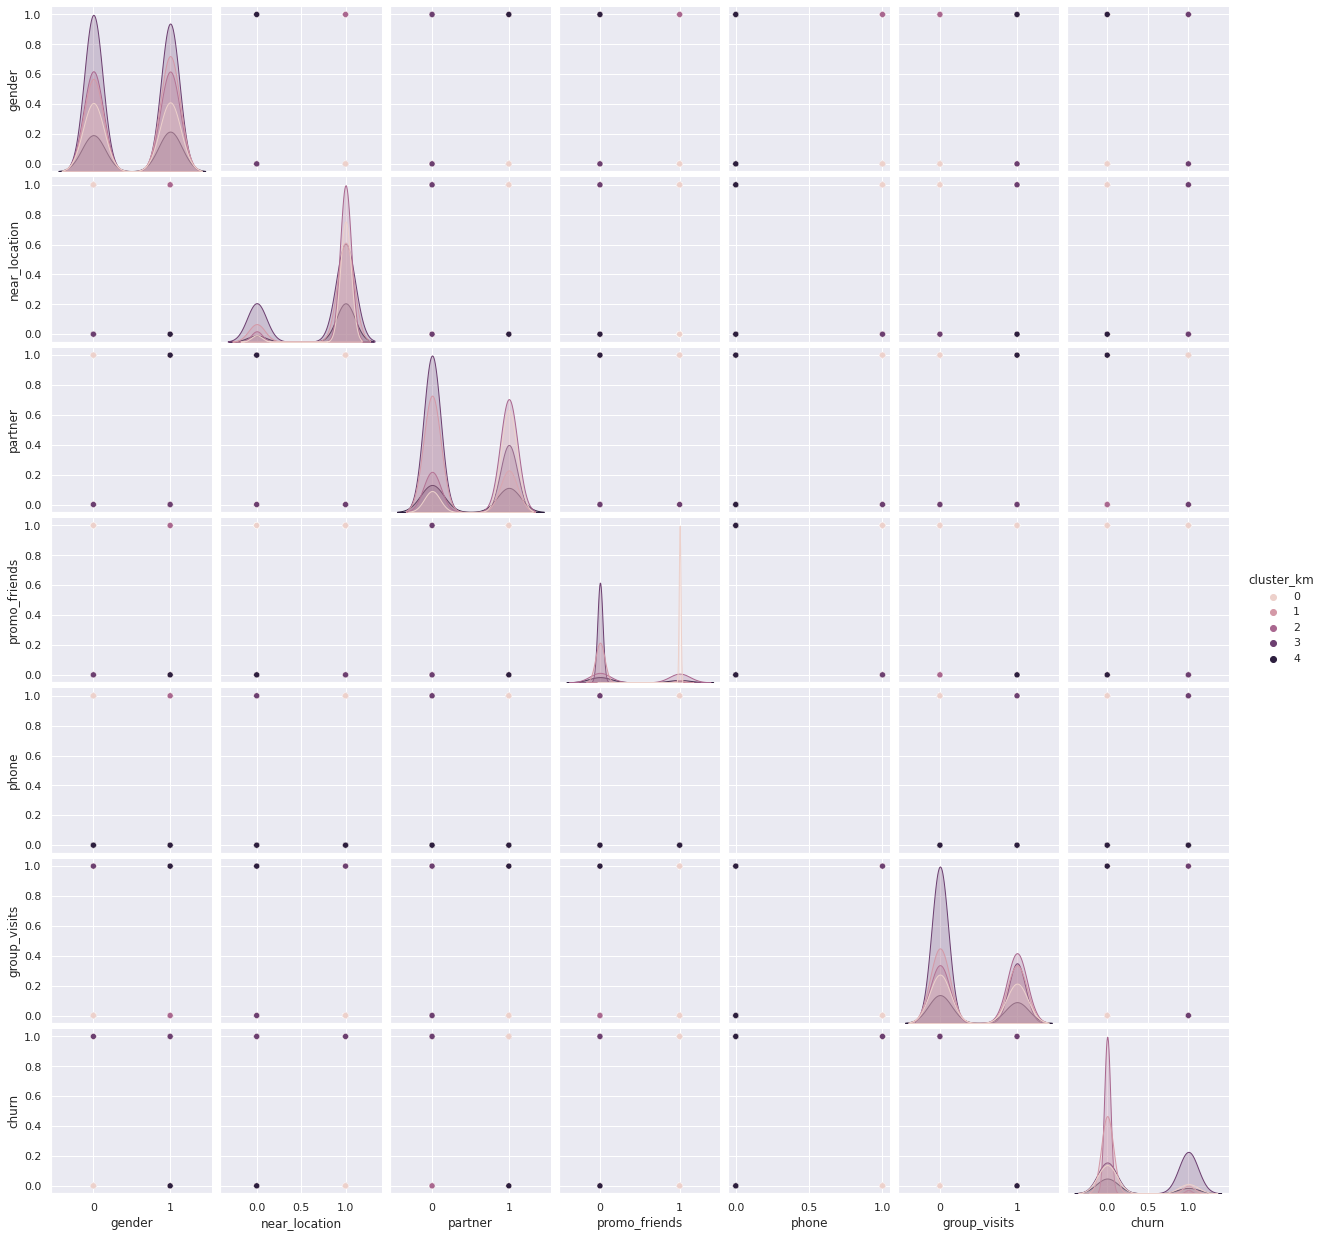

In [49]:
sns.pairplot(df.drop(numeric, axis=1), hue="cluster_km")
plt.show()

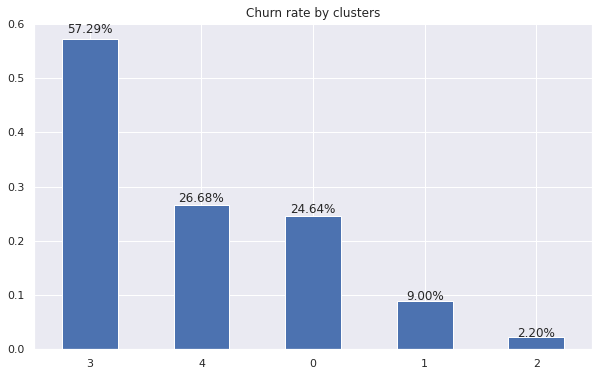

In [50]:
ax = df.groupby('cluster_km', as_index = False)\
    .mean().sort_values(by = 'churn', ascending = False)['churn']\
    .plot.bar(figsize = (10, 6))
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height * 1.02), ha = 'center')
plt.xticks(rotation = 0)
plt.title('Churn rate by clusters')
plt.show()

Our obtained 5 clusters have different churn rates: from **2.77% (cluster 0 is the most reliable)**, i.e. this cluster has remained almost at full strength since last month and up to **56% (cluster 3 is the most prone to churn)**, i.e. this cluster churned more than half last month.

# Conclusions and recommendations 
 
We have built a predictive model based on the` GradientBoostingClassifier` algorithm implementation. 

Now we can predict the probability of churn for each client.

The most important features affecting churn are **lifetime, monthly and total average visits, age, contract period and months to end contract**.

**Conclusion on feature distribution:**
* Gender distribution is about the same
* Most clients (85%) live or work near a fitness club
* Approximately half of clients are employees of partner organizations
* About 30% of clients came thanks to the promotion campaign
* Approximately 90% of clients have left their phone numbers
* Average contract period - 4.6 months
* About 40% of clients attend group classes
* Average age of clients 29 years
* Average additional costs per client - 146 dollars
* Average period until the end of the contract - 4.3 months
* Average frequency of visits over all of  the period - 1.87 times a week
* Average frequency of visits in the last month - 1.76 times a week
* Churn rate - 26.5%

**Conclusions based on differences in characteristics between customers who churned and those who remained:**

- The distribution by gender does not differ
- Closer living or working customers are less likely to end up in churn, which makes sense
- Employees of partner companies are less likely to stop visiting the fitness center than other clients
- Clients who came via the promotion campaign  are twice as likely to churn eventually
- The presence of a client’s phone number does not differ in groups nor is affecting the fact of churn
- The average contract period is obviously longer for the remaining users, for most  churned clients the period is 1 month, but this rather indicates that more often customers would  sign up for 1 month.
- Remaining clients visit group classes more often 
- The average age is different within the churned/not churned subgroups - 27/30 respectively
- There is a small difference in revenue from other fitness center services, however the value is lower for the churned subgroup
- Time remaining until the end of the contract is greater for the remaining clients.
- Churned clients have lower average number of visits per week for the entire time
- The number of visits in the previous month is half that of churn customers

**Conclusions upon customer segmentation:**

With the help of the K-means algorithm we clustered all our customers into 5 groups.
 
1. Cluster 0
 * Churn - **2.7% - the lowest**
 * Live or work near the fitness center
 * Employees of partner companies  - in 78% cases
 * Sign up for contracts for long term - **12 months on average**
 * Most of them attend group classes - in  54% cases
 * Most of them came via the promotion campaign
 > Those our best clients - a reward policy would be appropriate for those clients
1. Cluster 1
 * Churn - 26.7%
 * Live or work near a fitness center
 * **No mobile number**
 * The average duration of contracts is  4.5 months
 > An alterntive way of interaction is essential for those clients
2. Cluster 2
 * Churn - 44.3%
 * Similar to cluster 0, but live or work in another area, **not neighbors**
 * Only 7% came via the promo campaign
 * Least of all other clusters clients of this one attended group classes 
 > Clients of this cluster are soon to be churned. They need extra attention and engagement
3. Cluster 3
 * Churn - **51.4% - the highest**
 * Live or work near a fitness center
 * Mostly 1-3 month **short-term** membership holders
 * **Lowest** number of visits in total and for month
 > Revive their interest with a targeted campaign
4. Cluster 4
 * Churn - 6.8%
 * Live or work near fitness center
 * Have the highest average additional charges - **161(dollars)**
 * Most frequently visit the gym - **2.81 times** on average
 * Tend to sign up for contracts **NOT for a long period** - on average 2.8 months
 > Those are very good clients as well, but the contract period is short, maybe they need some extra loyalty program

**Recommendations:**

- There has to be a different strategy towards different client segments (cluster) that will take in account their unique characteristics
- Give a wider broadcast to the 'friend brings a friend' promotion campaign - clients who come as part of this promotion are less likely to churn, but the share of such clients is quit low overall.
- Establish alternative ways of communication with clients that didn't leave their phone numbers
- Don't spend too much time and effort on reacquiring the almost lost clients
- Integarte the machine learning approach to find more insights about the clients. 
